In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR

import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
plt.style.use('ggplot')

## Introduction

Education is a key factor for achieving a long-term economic progress. Modeling student performance is an important tool for both educators and students. In this brief analysis we use a UCI Machine Learning Repository [dataset](http://archive.ics.uci.edu/ml/datasets/Student+Performance) on the student math achievement in secondary education of two Portuguese schools.

## Dataset description

Explanatory variable Information:

1. school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira) 
2. sex - student's sex (binary: 'F' - female or 'M' - male) 
3. age - student's age (numeric: from 15 to 22) 
4. address - student's home address type (binary: 'U' - urban or 'R' - rural) 
5. famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3) 
6. Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart) 
7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education) 
8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education) 
9. Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
10. Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
11. reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other') 
12. guardian - student's guardian (nominal: 'mother', 'father' or 'other') 
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour) 
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) 
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4) 
16. schoolsup - extra educational support (binary: yes or no) 
17. famsup - family educational support (binary: yes or no) 
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) 
19. activities - extra-curricular activities (binary: yes or no) 
20. nursery - attended nursery school (binary: yes or no) 
21. higher - wants to take higher education (binary: yes or no) 
22. internet - Internet access at home (binary: yes or no) 
23. romantic - with a romantic relationship (binary: yes or no) 
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent) 
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high) 
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high) 
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high) 
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high) 
29. health - current health status (numeric: from 1 - very bad to 5 - very good) 
30. absences - number of school absences (numeric: from 0 to 93) 
31. G1 - first period grade (numeric: from 0 to 20) 
32. G2 - second period grade (numeric: from 0 to 20) 

Response variable:

G3 - final grade (numeric: from 0 to 20, output target)

## Models

We can consider modeling under two data mining goals:

> 1. regression, with a numeric output that ranges between zero (0%) and twenty (100%).

> 2. binary classification (pass/fail)

### Regression

In [2]:
original = pd.read_csv('./data/original.csv')

> A simple linear regression is applied first.

In [13]:
X = original.drop("G3", axis=1)
y = original.G3

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.33,random_state=1)

n = X_train.shape[0]
d = X_train.shape[1]

print("Number of training examples:", n)
print("Number of features:", d)

def fit_and_report(model, X, y, Xv, yv):
    model.fit(X,y)
    mean_squared_err = lambda y, yhat: np.mean((y-yhat)**2)
    errors = [mean_squared_err(y, model.predict(X)), mean_squared_err(yv, model.predict(Xv))]
    return errors
    
errs = fit_and_report(LinearRegression(), X_train, y_train, X_valid, y_valid)

print("Validation error: ", errs[1])

Number of training examples: 264
Number of features: 32
Validation error:  3.590095199619779


> Since the number of features is large here, we can add a regularized term to penalize the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. Here we fit an L2-regularized linear regression, a.k.a. Ridge regression, via scikit-learn's [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), to this data set. 

In [15]:
alphas = [10**(-2), 10**(-1), 1, 10**1, 10**2]

mean_squared_err = lambda y, yhat: np.mean((y-yhat)**2)

testError = list()

for al in alphas:
    ridge = Ridge(alpha=al)
    ridge.fit(X_train, y_train) 
    testError.append(mean_squared_err(y_valid, ridge.predict(X_valid)))

optimal_al = alphas[np.argmin(testError)]

ridge_opt = Ridge(alpha=optimal_al)
ridge_opt.fit(X, y)
print("Validation error:", mean_squared_err(y_valid, ridge_opt.predict(X_valid)))

Validation error: 2.7565994190850924


> Although the validation error improves, the regression method does not have a very satisfying result. So we can consider making the response variable binary to try the classification method.

### Binary Classification

In [16]:
dat = pd.read_csv('./data/binary.csv')

> We consider using the RandomForest classifier for the analysis since scaling is not necessary in this method.

In [18]:
np.random.seed(0)
X = dat.drop(["G3", "G3_PF"], axis=1)
y = dat.G3_PF

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=1)

model=RandomForestClassifier(random_state=1)
model.fit(X_train,y_train)
print('Validation Accuracy with all 32 features :',model.score(X_test,y_test))

Validation Accuracy with 32 features : 0.885496183206


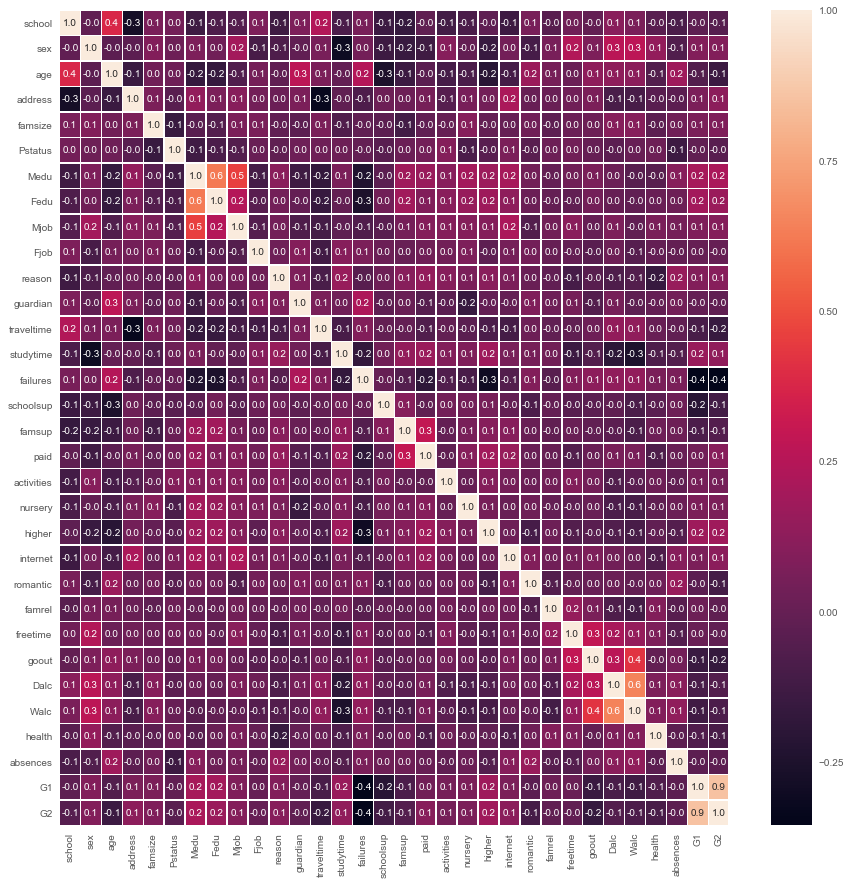

In [19]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

> We see that attributes G1 and G2 have a strong correlation. This occurs because G2 is the second year grade (issued at the 2nd period), while G1 corresponds to the 1st period grades. We might want to drop `G2` first.

In [22]:
np.random.seed(0)
X_drop1=X.drop(['G2'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X_drop1,y,test_size=0.33,random_state=1)

model=RandomForestClassifier(random_state=1)
model.fit(X_train,y_train)
print('Validation Accuracy with 31 features :',model.score(X_test,y_test))

Validation Accuracy with 31 features : 0.870229007634


> After we remove the values of `G2`, the validation accuracy surprisingly decreases. So it is more difficult to predict G3 without G2 and G1. We can keep the `G1` and `G2` attributes and try to remove other correlated attribute like `Walc` because weekend alcohol consumption seem to have little influence on the student's performance.

In [67]:
X_drop2=X.drop(['Walc'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X_drop2,y,test_size=0.33,random_state=1)

model=RandomForestClassifier(random_state=1)
model.fit(X_train,y_train)
print('Validation Accuracy with 31 features :', model.score(X_test,y_test))

Validation Accuracy with 31 features : 0.900763358779


> The validation accuracy increases from 0.885496183206 to 0.900763358779.

> Then we use RFECV to find the best subset of features.

In [95]:
subset=RFECV(estimator=RandomForestClassifier(random_state=1),cv=15)
subset=subset.fit(X_train,y_train)
feature_score=pd.Series(subset.grid_scores_,index=X_train.columns)
feature_score.sort_values()

school        0.887157
romantic      0.924527
internet      0.928036
G1            0.930891
health        0.931327
Dalc          0.935661
goout         0.935879
paid          0.936074
absences      0.936292
age           0.939995
Fedu          0.942679
activities    0.942679
famsup        0.943309
sex           0.943917
Fjob          0.946382
famsize       0.946577
higher        0.946600
guardian      0.946795
studytime     0.946795
nursery       0.947013
Medu          0.947013
famrel        0.947013
failures      0.950717
schoolsup     0.950740
Pstatus       0.951129
G2            0.954225
address       0.954420
freetime      0.958147
Mjob          0.958147
traveltime    0.958342
reason        0.958560
dtype: float64

In [96]:
print('Optimal number of features :', subset.n_features_)
print('Best features :', X_train.columns[subset.support_])

Optimal number of features : 11
Best features : Index(['age', 'Medu', 'Mjob', 'failures', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'G1', 'G2'],
      dtype='object')


In [97]:
features=X_train.columns[subset.support_]
X_train_opt=X_train[features]
X_test_opt=X_test[features]

model.fit(X_train_opt,y_train)
print('Validation Accuracy with 11 features :', model.score(X_test_opt,y_test))

Validation Accuracy with 11 features : 0.900763358779


> It is nice that we can decrease the number of features to 11 and still keep the accuracy rate of 90% high.

## Conclusion

We have addressed the prediction of secondary student grades of Mathematics by using past school grades, demographic, social and other school related data. And we finally keep 11 most relevant explanatory variables. More research is also needed in order to understand why and how some variables (e.g. parent’s job or freetime) affect student performance.